In [66]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

In [67]:
np.random.seed(42)

R_CSV = "../gpt_generated_data/user_course_ratings_realistic.csv"   # path to your prepared 100x20 CSV
K = 8                   # latent dimensions
LR = 0.01               # learning rate
REG = 0.05              # regularization
EPOCHS = 50
TOP_K = 5               # for precision@5 / recall@5

### Load dataset

In [88]:
ratings_df = pd.read_csv(R_CSV, index_col=0)   
R = ratings_df.values.astype(float)            
users = ratings_df.index.to_list()
items = ratings_df.columns.to_list()
n_users, n_items = R.shape
print("Loaded R shape:", R.shape)


Loaded R shape: (100, 20)


#### Helper: nonzero indices

In [91]:
nonzero_positions = np.array(np.nonzero(R)).T   # list of (u,i) with R[u,i] != 0
print("Nonzero ratings count:", nonzero_positions.shape[0])
np.array(np.nonzero(R))

Nonzero ratings count: 698


array([[ 0,  0,  0, ..., 99, 99, 99],
       [ 3,  5,  8, ..., 10, 11, 18]], shape=(2, 698))

#### Train/test split on nonzero entries

In [70]:
def train_test_split_nonzero(R, test_frac=0.2, random_state=42):
    rng = np.random.RandomState(random_state)
    u_idx, i_idx = np.nonzero(R)
    pairs = list(zip(u_idx, i_idx))
    rng.shuffle(pairs)
    n_test = int(len(pairs) * test_frac)
    test_pairs = pairs[:n_test]
    train_pairs = pairs[n_test:]
    R_train = np.zeros_like(R)
    R_test = np.zeros_like(R)
    for (u, i) in train_pairs:
        R_train[u, i] = R[u, i]
    for (u, i) in test_pairs:
        R_test[u, i] = R[u, i]
    return R_train, R_test, train_pairs, test_pairs

R_train, R_test, train_pairs, test_pairs = train_test_split_nonzero(R, test_frac=0.2, random_state=42)
print("Train nonzero:", len(train_pairs), "Test nonzero:", len(test_pairs))


Train nonzero: 559 Test nonzero: 139


### Matrix Factorization via SGD

In [103]:
def matrix_factorization_sgd(R_train, k=8, lr=0.01, reg=0.02, epochs=50, verbose=True):
    n_users, n_items = R_train.shape
    # Initialize P and Q with small random values
    P = 0.1 * np.random.randn(n_users, k)
    Q = 0.1 * np.random.randn(n_items, k)

    # Precompute list of observed indices
    obs = list(zip(*np.nonzero(R_train)))
    rmse_hist = []
    for ep in range(epochs):
        np.random.shuffle(obs)
        for (u, i) in obs:
            r_ui = R_train[u, i]
            pred = P[u, :].dot(Q[i, :])
            e = r_ui - pred
            # SGD updates with regularization
            P[u, :] += lr * (e * Q[i, :] - reg * P[u, :])
            Q[i, :] += lr * (e * P[u, :] - reg * Q[i, :])
        # compute RMSE on train observed entries
        preds = P.dot(Q.T)
        mask = (R_train > 0)
        se = ((mask * (R_train - preds)) ** 2).sum()
        n_obs = mask.sum()
        rmse = np.sqrt(se / n_obs) if n_obs>0 else np.nan
        rmse_hist.append(rmse)
        if verbose and (ep % max(1, epochs//10) == 0 or ep==epochs-1):
            print(f"Epoch {ep+1}/{epochs} RMSE(train) = {rmse:.4f}")
    return P, Q, rmse_hist

P, Q, rmse_hist = matrix_factorization_sgd(R_train, k=K, lr=LR, reg=REG, epochs=EPOCHS, verbose=True)


Epoch 1/50 RMSE(train) = 3.6945
Epoch 6/50 RMSE(train) = 3.1887
Epoch 11/50 RMSE(train) = 0.8943
Epoch 16/50 RMSE(train) = 0.5543
Epoch 21/50 RMSE(train) = 0.5049
Epoch 26/50 RMSE(train) = 0.4828
Epoch 31/50 RMSE(train) = 0.4640
Epoch 36/50 RMSE(train) = 0.4467
Epoch 41/50 RMSE(train) = 0.4301
Epoch 46/50 RMSE(train) = 0.4130
Epoch 50/50 RMSE(train) = 0.3991


### Predictions

In [106]:
R_hat = P.dot(Q.T)

### User-based CF & Item-based CF implementations

In [73]:
# We'll use cosine similarity.
def user_based_predict(R_train):
    # user-user similarity
    sim = cosine_similarity(R_train)
    # zero diag
    np.fill_diagonal(sim, 0)
    # predict: weighted sum normalized by abs(sim) sum
    pred = sim.dot(R_train)
    denom = np.abs(sim).sum(axis=1, keepdims=True)
    denom[denom == 0] = 1e-9
    pred = pred / denom
    return pred

def item_based_predict(R_train):
    # item-item similarity
    sim_items = cosine_similarity(R_train.T)
    np.fill_diagonal(sim_items, 0)
    pred = R_train.dot(sim_items)
    denom = np.abs(sim_items).sum(axis=1, keepdims=True).T  # shape (n_users, n_items)
    denom[denom == 0] = 1e-9
    pred = pred / denom
    return pred

R_hat_user = user_based_predict(R_train)
R_hat_item = item_based_predict(R_train)


### Recommendation function (top-k unseen)

In [74]:
def top_k_recommendations_for_user(pred_matrix, R_seen, user_idx, k=5):
    preds = pred_matrix[user_idx].copy()
    # mask seen items
    seen = R_seen[user_idx] > 0
    preds[seen] = -np.inf
    topk_idx = np.argsort(preds)[-k:][::-1]
    return topk_idx

# Example: recommendations for user 0
print("MF top-5 for user 0:", top_k_recommendations_for_user(R_hat, R_train, 0, k=5))
print("UserCF top-5 for user 0:", top_k_recommendations_for_user(R_hat_user, R_train, 0, k=5))
print("ItemCF top-5 for user 0:", top_k_recommendations_for_user(R_hat_item, R_train, 0, k=5))

MF top-5 for user 0: [17 10 19  8 15]
UserCF top-5 for user 0: [ 8 17 18  1  0]
ItemCF top-5 for user 0: [18  1  8 14  6]


### Evaluation: RMSE on test set

In [75]:
def rmse_on_masked(R_true, R_pred, mask):
    se = ((mask * (R_true - R_pred)) ** 2).sum()
    n = mask.sum()
    return np.sqrt(se / n) if n>0 else np.nan

test_mask = (R_test > 0)
rmse_mf_test = rmse_on_masked(R_test, R_hat, test_mask)
rmse_user_test = rmse_on_masked(R_test, R_hat_user, test_mask)
rmse_item_test = rmse_on_masked(R_test, R_hat_item, test_mask)
print("\nTest RMSEs:")
print("MF:", rmse_mf_test)
print("UserCF:", rmse_user_test)
print("ItemCF:", rmse_item_test)



Test RMSEs:
MF: 0.7489188262014799
UserCF: 2.7049247699759595
ItemCF: 2.69536570681079


### Precision@K and Recall@K

In [76]:
def precision_recall_at_k(R_true, R_pred, k=5, threshold=4):
    """
    Compute precision@k and recall@k.
    Relevant items are those with rating >= threshold in R_true.
    """
    precisions, recalls = [], []

    n_users, n_items = R_true.shape
    for u in range(n_users):
        # true relevant items
        relevant = np.where(R_true[u, :] >= threshold)[0]
        if len(relevant) == 0:
            continue  # skip if user has no relevant items

        # predicted top-k
        top_k = np.argsort(R_pred[u, :])[::-1][:k]

        # intersection
        hits = np.intersect1d(top_k, relevant)

        # precision = hits / k
        precisions.append(len(hits) / k)

        # recall = hits / relevant items
        recalls.append(len(hits) / len(relevant))

    return np.mean(precisions), np.mean(recalls)

prec_mf, rec_mf = precision_recall_at_k(R_test, R_hat, k=TOP_K, threshold=4)
prec_user, rec_user = precision_recall_at_k(R_test, R_hat_user, k=TOP_K, threshold=4)
prec_item, rec_item = precision_recall_at_k(R_test, R_hat_item, k=TOP_K, threshold=4)

print("\nPrecision@5 / Recall@5:")
print(f"MF:   prec={prec_mf:.4f}, rec={rec_mf:.4f}")
print(f"User: prec={prec_user:.4f}, rec={rec_user:.4f}")
print(f"Item: prec={prec_item:.4f}, rec={rec_item:.4f}")


Precision@5 / Recall@5:
MF:   prec=0.0760, rec=0.2200
User: prec=0.0640, rec=0.2133
Item: prec=0.0960, rec=0.3067


### Compare recommendation lists for 5 random users

In [107]:
rng = np.random.RandomState(1)
sample_users = rng.choice(n_users, size=5, replace=False)
rec_table = []
for u in sample_users:
    rec_mf_c = top_k_recommendations_for_user(R_hat, R_train, u, k=TOP_K)
    rec_usercf = top_k_recommendations_for_user(R_hat_user, R_train, u, k=TOP_K)
    rec_itemcf = top_k_recommendations_for_user(R_hat_item, R_train, u, k=TOP_K)
    rec_table.append({
        "user": users[u],
        "mf": [items[i] for i in rec_mf_c],
        "usercf": [items[i] for i in rec_usercf],
        "itemcf": [items[i] for i in rec_itemcf]
    })

import json
with open("recommendations.json", "w") as f:
    json.dump(rec_table, f, indent=4)

pd.set_option('display.width', 120)
print("\nRecommendations (5 sample users):")
print(pd.DataFrame(rec_table))


Recommendations (5 sample users):
      user                                                 mf                                             usercf  \
0  user_80  [course_10, course_17, course_15, course_19, c...  [course_8, course_17, course_19, course_0, cou...   
1  user_84  [course_10, course_16, course_14, course_11, c...  [course_11, course_8, course_7, course_12, cou...   
2  user_33  [course_10, course_17, course_18, course_19, c...  [course_11, course_9, course_0, course_17, cou...   
3  user_81  [course_10, course_17, course_19, course_18, c...  [course_11, course_0, course_17, course_9, cou...   
4  user_93  [course_17, course_10, course_15, course_18, c...  [course_9, course_17, course_8, course_18, cou...   

                                              itemcf  
0  [course_18, course_17, course_5, course_19, co...  
1  [course_12, course_10, course_8, course_13, co...  
2  [course_11, course_10, course_12, course_2, co...  
3  [course_0, course_18, course_10, course_9, co

### Factor interpretation


Top-3 items per latent factor:
factor_0 ['course_16', 'course_10', 'course_2']
factor_1 ['course_19', 'course_14', 'course_18']
factor_2 ['course_3', 'course_17', 'course_14']
factor_3 ['course_10', 'course_15', 'course_8']
factor_4 ['course_18', 'course_1', 'course_11']
factor_5 ['course_1', 'course_8', 'course_9']
factor_6 ['course_0', 'course_2', 'course_16']
factor_7 ['course_11', 'course_17', 'course_4']


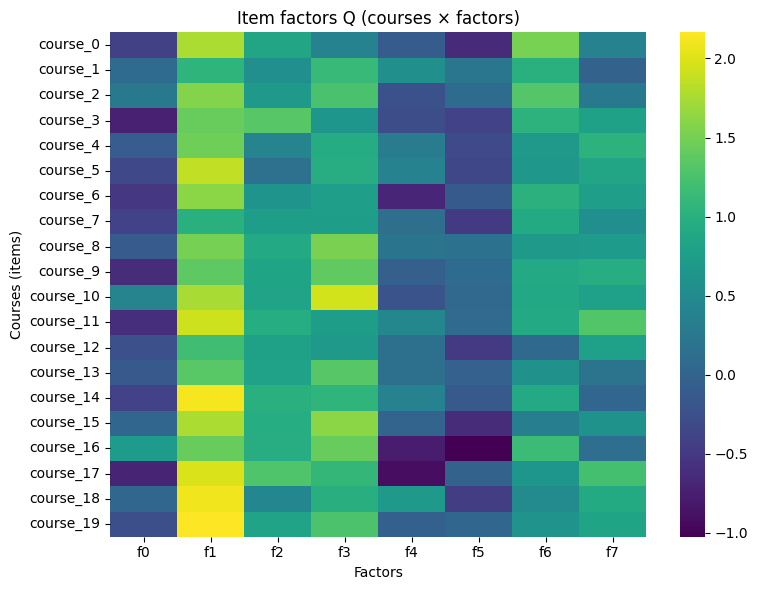

In [ ]:
n_factors = Q.shape[1]
factor_topk = {}
for j in range(n_factors):
    top3 = np.argsort(Q[:, j])[-3:][::-1]
    factor_topk[f"factor_{j}"] = [items[i] for i in top3]
print("\nTop-3 items per latent factor:")
for kf, top_items in factor_topk.items():
    print(kf, top_items)

# Heatmap of Q (courses × factors)
plt.figure(figsize=(8, 6))
sns.heatmap(Q, cmap="viridis", yticklabels=items, xticklabels=[f"f{j}" for j in range(Q.shape[1])])
plt.title("Item factors Q (courses × factors)")
plt.xlabel("Factors")
plt.ylabel("Courses (items)")
plt.tight_layout()
plt.show()

### Plot RMSE history

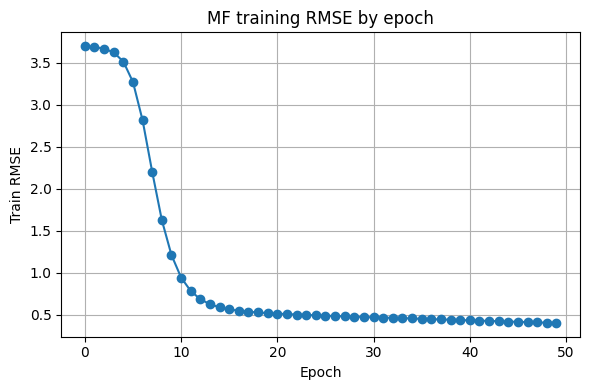

In [79]:
plt.figure(figsize=(6,4))
plt.plot(rmse_hist, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Train RMSE")
plt.title("MF training RMSE by epoch")
plt.grid(True)
plt.tight_layout()
plt.show()

### Final metrics table

In [80]:
metrics = pd.DataFrame({
    "method": ["MatrixFactorization", "UserCF", "ItemCF"],
    "rmse_test": [rmse_mf_test, rmse_user_test, rmse_item_test],
    "prec@5": [prec_mf, prec_user, prec_item],
    "recall@5": [rec_mf, rec_user, rec_item]
})
print("\nMetrics summary:")
print(metrics)



Metrics summary:
                method  rmse_test  prec@5  recall@5
0  MatrixFactorization   0.748919   0.076  0.220000
1               UserCF   2.704925   0.064  0.213333
2               ItemCF   2.695366   0.096  0.306667
